In [3]:
!conda install -y -c pytorch torchaudio

Solving environment: / 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/noarch::numpydoc==0.9.2=py_0
  - defaults/noarch::sphinx==2.4.4=py_0
  - defaults/noarch::s3fs==0.4.0=py_0
  - defaults/linux-64::spyder==4.1.2=py36_0
failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: / 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/noarch::numpydoc==0.9.2=py_0
  - defaults/noarch::sphinx==2.4.4=py_0
  - defaults/noarch::s3fs==0.4.0=py_0
  - defaults/linux-64::spyder==4.1.2=py36_0
done

## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/pytorch_p36

  added / updated specs:
    - torchaudio


The following packages will be downloaded:

    package    

Frome terminal download the common voice dataset for the following languages: 'de', 'en', 'es', 'fr', 'it', 'ru'

Below you can find the set of commands to download English corpus. (You can get the link from common voice website: https://voice.mozilla.org/en

In [4]:
#!cd ./data

#!mkdir en
#!cd en
#!wget 'https://voice-prod-bundler-ee1969a6ce8178826482b88e843c335139bd3fb4.s3.amazonaws.com/cv-corpus-4-2019-12-10/en.tar.gz
#!tar -xzf en.tar.gz

In [5]:
import IPython.display as ipd
filename='./data/es/clips/common_voice_es_19132695.mp3'
ipd.Audio(filename)

In [6]:
import torchaudio

waveform, sample_rate = torchaudio.load(filename)

print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))
print("Audio length: {} seconds".format(waveform.size()[1]/sample_rate))

Shape of waveform: torch.Size([1, 328320])
Sample rate of waveform: 48000
Audio length: 6.84 seconds


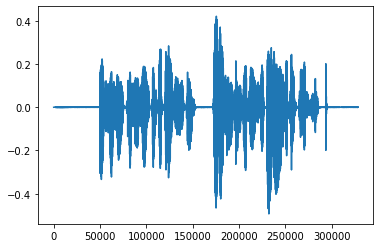

In [7]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(waveform.t().numpy())


In [8]:
filename='./data/en/clips/common_voice_en_17966292.mp3'
ipd.Audio(filename)

In [9]:
waveform, sample_rate = torchaudio.load(filename)

print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))
print("Audio length: {} seconds".format(waveform.size()[1]/sample_rate))

Shape of waveform: torch.Size([1, 211968])
Sample rate of waveform: 48000
Audio length: 4.416 seconds


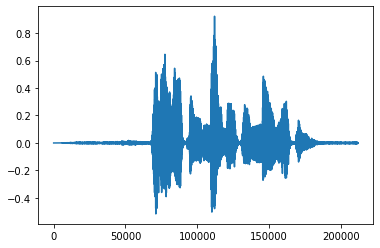

In [10]:
plt.figure()
plt.plot(waveform.t().numpy())

In [11]:
import glob
import os
input_dir="data"

all_langs = sorted([os.path.basename(dir) for dir in glob.glob("./%s/*" % input_dir)])

print(all_langs)

['de', 'en', 'es', 'it', 'ru']


Sample 1000 audio files for each language and store them in a list. Each record contains the following elements in a tuple:

* language code
* wave signal time series values
* file name

In [12]:
import random
from pathlib import Path
import torch
import torchaudio

sample_count = 1000

records = []

for lang in all_langs:
    print(f"Sampling for lang {lang}")
    all_mp3s = glob.glob(input_dir + "/" + lang + "/clips/*.mp3")
    random.shuffle(all_mp3s)
    sample_mp3s = all_mp3s[0:min(sample_count, len(all_mp3s))]
    for mp3_file in sample_mp3s:
        try:
            waveform, sample_rate = torchaudio.load(mp3_file)
        except Exception as e:
            print("Failed to open {}: {}".format(mp3_file, e))
        assert waveform.size()[0] == 1, "we assume they all have one channel"
        assert sample_rate == 48000, "we assume that sample rate for all files are the same and equal to 48000"
        records.append((lang, waveform[0], os.path.basename(mp3_file)))

Sampling for lang de
Sampling for lang en
Sampling for lang es
Sampling for lang it
Sampling for lang ru


In [13]:
records[0]

('de', tensor([0., 0., 0.,  ..., 0., 0., 0.]), 'common_voice_de_19528412.mp3')

In [14]:
import numpy as np
lens = np.asarray([len(record[1]) for record in records])

In [15]:
print("Signal lens distribution: min: %s, median: %s, mean: %s, max: %s, std: %s" % (lens.min(), lens.mean(), np.median(lens), lens.max(), lens.std()))


Signal lens distribution: min: 3456, median: 245867.4432, mean: 237312.0, max: 633600, std: 87588.46088119356


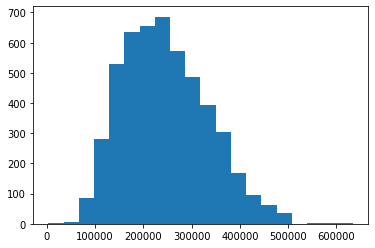

In [16]:
import matplotlib.pyplot as plt

plt.hist(lens, bins =20)
plt.show()

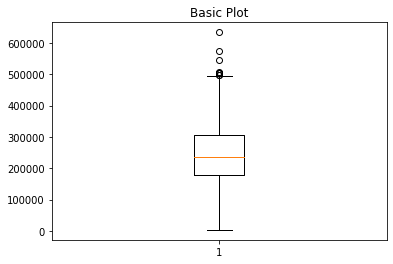

In [17]:
import numpy as np
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
a = ax1.boxplot(lens)

In [190]:
signal_len = int(np.percentile(lens, 50))

In [191]:
print("signal is for %s seconds of voice" % str(signal_len/sample_rate))

signal is for 4.944 seconds of voice


In [192]:
lang_to_index = {l: i for i, l in enumerate(all_langs)}
index_to_lang = {i: l for i, l in enumerate(all_langs)}

Split the input labled data into train and validation data sets

In [197]:
from torch.utils.data import Dataset
import torch
import random

class LangDataset(Dataset):

    def __init__(self, records):
        self.records = records
        
    def __getitem__(self, i):
        record = self.records[i]
        signal_tensor_np = np.zeros(signal_len, dtype='float32')
        l = min(len(record[1]), signal_len)
        m = len(record[1]) // 2
        signal_tensor_np[:l] = record[1][m - l//2:m + l//2]
        x = torch.tensor(signal_tensor_np)
        y = torch.tensor(lang_to_index[record[0]])
        return x, y
    
    def __len__(self):
        return len(self.records)

random.shuffle(records)
t_n = len(records) * 2 // 3
train_records = records[0:t_n]
valid_records = records[t_n:]

train_set = LangDataset(train_records)
valid_set = LangDataset(valid_records)

print(len(train_set))
print(len(valid_set))

kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {} #needed for using datasets on gpu

train_loader = torch.utils.data.DataLoader(train_set, batch_size = 64, shuffle = True, **kwargs)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size = 64, shuffle = False, **kwargs)

3333
1667


The following network is inspired by:
    
* https://arxiv.org/pdf/1910.04269.pdf
* https://github.com/MODU-FTNC/pytorch-tutorials/blob/master/beginner_source/audio_classifier_tutorial.py
* https://arxiv.org/pdf/1610.00087.pdf
        

In [235]:
import torch.nn as nn

output_size = len(all_langs)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(1, 128, 100, 8)
        self.bn1 = nn.BatchNorm1d(128)
        self.d1 = nn.Dropout(0.1)
        self.pool1 = nn.MaxPool1d(8)
        self.conv2 = nn.Conv1d(128, 128, 4)
        self.bn2 = nn.BatchNorm1d(128)
        self.d2 = nn.Dropout(0.1)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(128, 256, 2)
        self.bn3 = nn.BatchNorm1d(256)
        self.d3 = nn.Dropout(0)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(256, 512, 1)
        self.bn4 = nn.BatchNorm1d(512)
        self.d4 = nn.Dropout(0)
        self.pool4 = nn.MaxPool1d(8)
        self.avgPool = nn.AvgPool1d(22) #30) #input should be 512x30 so this outputs a 512x1
        self.fc1 = nn.Linear(512, 100)
        self.d5 = nn.Dropout(0)
        self.fc2 = nn.Linear(100, output_size)
    def forward(self, x):
        #print(x.shape) # [64, 23500]
        x = x.unsqueeze(1)
        #print(x.shape) # torch.Size([64, 1, 23500])
        x = self.conv1(x)
        #print(x.shape) # torch.Size([64, 128, 2926])
        x = F.relu(self.d1(self.bn1(x)))
        x = self.pool1(x)
        #print(x.shape) # torch.Size([64, 128, 365])
        x = self.conv2(x)
        x = F.relu(self.d2(self.bn2(x)))
        x = self.pool2(x)
        #print(x.shape) # torch.Size([64, 128, 90])
        x = self.conv3(x)
        x = F.relu(self.d3(self.bn3(x)))
        #print(x.shape) # torch.Size([64, 256, 89])
        x = self.pool3(x)
        #print(x.shape) # torch.Size([64, 256, 22])
        x = self.conv4(x)
        #print(x.shape) # torch.Size([64, 512, 22])
        x = F.relu(self.d4(self.bn4(x)))
        #print(x.shape) # torch.Size([64, 512, 22]
        x = self.pool4(x)
        #print(x.shape) # torch.Size([64, 512, 5])
        x = self.avgPool(x)
        #print(x.shape)
        x = x.permute(0, 2, 1) #change the 512x1 to 1x512
        #print(x.shape)
        x = F.relu(self.d5(self.fc1(x)))
        x = self.fc2(x)
        #print(x.shape)
        x = x.reshape(x.shape[0],-1)
        #print(x.shape)
        return x

The following network architecture is inspired by WaveNet: https://arxiv.org/pdf/1609.03499.pdf

In [236]:
output_size = len(all_langs)

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 128, kernel_size=1000, stride=16, padding=0)
        self.bn1 = nn.BatchNorm1d(128)
        self.d1 = nn.Dropout(0.7)
        self.conv2 = nn.Conv1d(128, 128, kernel_size=80, stride=8, padding=0, dilation=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.d2 = nn.Dropout(0.7)
        self.conv3 = nn.Conv1d(128, 512, kernel_size=40, stride=2, padding=0, dilation=2)
        self.bn3 = nn.BatchNorm1d(512)
        self.d3 = nn.Dropout(0.7)
        self.conv4 = nn.Conv1d(512, 512, kernel_size=20, stride=2, padding=0, dilation=2)
        self.bn4 = nn.BatchNorm1d(512)
        #self.d4 = nn.Dropout(0.7)
        self.conv5 = nn.Conv1d(512, 512, kernel_size=100, stride=2, padding=0, dilation=2)
        self.bn5 = nn.BatchNorm1d(512)
        #self.d5 = nn.Dropout(0.7)
        self.maxPool = nn.MaxPool1d(4)
        self.avgPool = nn.AvgPool1d(4)
        self.lin1 = nn.Linear(512 * 10, 100)
        self.d6 = nn.Dropout(0)
        self.lin2 = nn.Linear(150, 30)
        self.d7 = nn.Dropout(0)
        self.lin3 = nn.Linear(30, 10)
        self.d8 = nn.Dropout(0)
        self.lin4 = nn.Linear(100, output_size)
        self.d9 = nn.Dropout(0)
    def forward(self, xb):
        bs = xb.shape[0]
        xb = xb.unsqueeze(1)
        xb = self.conv1(xb)
        xb = self.d1(xb)
        xb = F.relu(self.bn1(xb))
        #print(xb.shape)  # torch.Size([64, 128, 1477])
        xb = self.conv2(xb)
        xb = self.d2(xb)
        xb = F.relu(self.bn2(xb))
        #print(xb.shape)  # torch.Size([64, 128, 165])
        xb = self.conv3(xb)
        xb = self.d3(xb)
        xb = F.relu(self.bn3(xb))
        #print(xb.shape)  # torch.Size([64, 32, 44])
        #xb = self.conv4(xb)
        #xb = F.relu(self.bn4(xb))
        #print(xb.shape)  # torch.Size([64, 16, 3])
        #xb = self.maxPool(xb)
        #print(xb.shape)
        xb = self.avgPool(xb)
        #xb = self.conv5(xb)
        #xb = self.bn5(xb)
        #print(xb.shape) # ([64, 512, 10])
        xb = xb.view(bs, -1)
        #print(xb.shape) # torch.Size([64, 22528])
        xb = F.relu(self.lin1(xb))
        #print(xb.shape)
        #xb = self.d6(F.relu(self.lin2(xb)))
        #xb = self.d7(F.relu(self.lin3(xb)))
        xb = self.lin4(xb)
        #print(xb.shape)
        return xb

Run a sanity test to make sure network matches the shapes of tensors

In [239]:
for x, y in train_loader:
    print(x.shape)

    cnn = Net()
    o = cnn(x)
    print(o.shape)
    assert o.shape[1] == output_size
    
    # needs cleanup
    #cnn = CNN()
    #o = cnn(x)
    #print(o.shape)
    break

torch.Size([64, 237312])
torch.Size([64, 5])


In [240]:
from torch import optim

lr = 0.00005
def get_model():
    model = Net()
    #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 20, gamma = 0.1)
    return model, optim.Adam(model.parameters(), lr=lr, weight_decay = 0.01)

In [241]:
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"
device = torch.device(dev)
device

device(type='cuda', index=0)

In [242]:
model, opt = get_model()
model = model.to(device)
model

Net(
  (conv1): Conv1d(1, 128, kernel_size=(100,), stride=(8,))
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (d1): Dropout(p=0.1, inplace=False)
  (pool1): MaxPool1d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(128, 128, kernel_size=(4,), stride=(1,))
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (d2): Dropout(p=0.1, inplace=False)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(128, 256, kernel_size=(2,), stride=(1,))
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (d3): Dropout(p=0, inplace=False)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(256, 512, kernel_size=(1,), stride=(1,))
  (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (d4): Dropout(p=0, inplace=

In [243]:
import torch.nn.functional as F
loss_func = F.cross_entropy

log_interval = 20

def train(model, epoch, data_loader):
    print("\n\n#### Starting training epoch %s ####\n\n" % epoch)
    model.train()
    for batch_idx, (x, y) in enumerate(data_loader):
        opt.zero_grad()
        x = x.to(device)
        y = y.to(device)
        pred = model(x)
        loss = loss_func(pred, y) #the loss functions expects a batchSizex10 input
        loss.backward()
        opt.step()
        if batch_idx % log_interval == 0: #print training stats
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss))

In [244]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

def test(model, epoch, data_loader, label):
    print("\n\n******* Evaluate %s *******\n" % label)
    model.eval()
    y_pred = []
    y_true = []
    correct = 0
    for x, y in data_loader:
        x = x.to(device)
        y = y.to(device)
        preds = torch.argmax(model(x), dim=1)
        y_pred.extend(preds.tolist())
        y_true.extend(y.tolist())
        correct += (preds == y).float().sum()
    print('\nAccuracy: {}/{} ({:.4f}%)'.format(
        correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))
    print("\nConfusion metrics: \n%s" % confusion_matrix(y_true, y_pred))

Ran the following training logic SageMaker notebook on a GPU instance (p3.2xlarge)

In [ ]:
for epoch in range(1, 1000):
    train(model, epoch, train_loader)
    test(model, epoch, train_loader, 'Train')
    test(model, epoch, valid_loader, 'Validation')



#### Starting training epoch 1 ####


Train Epoch: 1 [0/3333 (0%)]	Loss: 1.634581
Train Epoch: 1 [1280/3333 (38%)]	Loss: 1.550365
Train Epoch: 1 [2560/3333 (75%)]	Loss: 1.478323


******* Evaluate Train *******


Accuracy: 948.0/3333 (28.4428%)

Confusion metrics: 
[[416 100  18 121   9]
 [360 162  12 119   7]
 [287 117  50 201  16]
 [306  96  13 248  22]
 [276  79   8 218  72]]


******* Evaluate Validation *******


Accuracy: 474.0/1667 (28.4343%)

Confusion metrics: 
[[228  38   8  59   3]
 [197  81   5  56   1]
 [157  41  18 105   8]
 [137  48  11 102  17]
 [125  48   7 122  45]]


#### Starting training epoch 2 ####


Train Epoch: 2 [0/3333 (0%)]	Loss: 1.545053
Train Epoch: 2 [1280/3333 (38%)]	Loss: 1.538839
Train Epoch: 2 [2560/3333 (75%)]	Loss: 1.519089


******* Evaluate Train *******


Accuracy: 1142.0/3333 (34.2634%)

Confusion metrics: 
[[106 396  58  56  48]
 [ 72 478  36  33  41]
 [ 75 301 134  70  91]
 [ 63 314  66 132 110]
 [ 62 207  46  46 292]]


******* Evaluate Val